In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
import seaborn as sns

In [2]:
def normal(x, mu, sigma):
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x - mu)**2/(2*sigma**2))

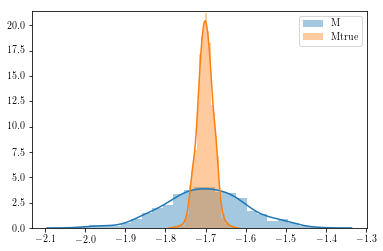

In [3]:
npts = 1000
sigma = 0.02
mean = -1.7
M_true = np.random.randn(npts) * sigma + mean
unc = 0.1
M = M_true + np.random.randn(npts) * unc
sns.distplot(M, label='M')
sns.distplot(M_true, label='Mtrue')
plt.legend()

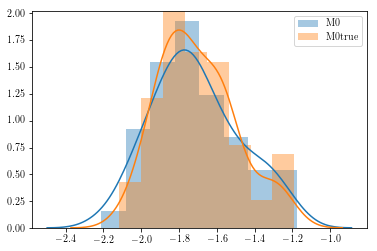

In [4]:
npts = 100
sigma0 = 0.2
mean0=-1.7
M_true0 = np.random.randn(npts) * sigma0 + mean0
M0 = M_true0 + np.random.randn(npts) * unc
sns.distplot(M0, label='M0')
sns.distplot(M_true0, label='M0true')
plt.legend()

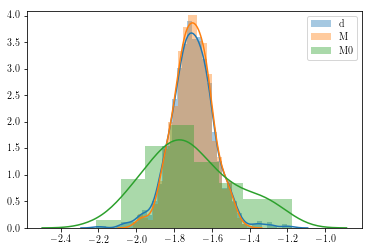

In [5]:
sns.distplot(np.append(M, M0),label='d')
sns.distplot(M, label='M')
sns.distplot(M0,label='M0')
plt.legend()
plt.show()

In [6]:
local = True
if local:
    clump_model = '''
    data {
        int<lower=0> N;
        real M[N];
        real<lower = 0> M_err[N];
    }
    parameters {
        real mu;
        real muo;
        real<lower=0.> sigma;
        real<lower=0.> sigo;
        real<lower=0., upper=1.> Q;
        real M_true_std[N];
    }
    transformed parameters{
        real M_true[N];
        real tmuo;
        real<lower=0.> tsigo;
        
        for (n in 1:N){
            M_true[n] = mu + sigma * M_true_std[n];
        }
        tmuo = muo - mu;
        tsigo = sigo / sigma;
    }
    
    model {   
        M ~ normal(M_true, M_err); // Measurement uncertainty
        mu ~ normal(-1.7,.1);
        sigma ~ normal(0.1,0.05);
        muo ~ normal(-1.7, .1);
        sigo ~ normal(0.2, 0.1);
        Q ~ normal(.9,.01);
        for (n in 1:N){
            target += log_mix(Q,
                        normal_lpdf(M_true_std[n]|0, 1),
                        normal_lpdf(M_true_std[n]|tmuo, tsigo));
        }
    }

    '''
    sm = pystan.StanModel(model_code=clump_model, model_name='ClumpModel')
else:
    import pickle
    print('Loading in existing Stan Model') 
    sm = pickle.load(open('asterostan.pkl', 'rb'))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL ClumpModel_2d008025427faab47afa41d6697c3120 NOW.


In [7]:
d = np.append(M, M0)
print(len(M))
print(len(d))
pQ = float(len(M))/float(len(d))
print(pQ)

1000
1100
0.909090909091


In [9]:
dat = {'N': len(d),
      'M': d,
      'M_err': np.ones(len(d))*unc}
start = [{'mu':mean,
         'sigma':sigma,
         'muo':mean0,
         'sigo':sigma0,
         'Q':pQ}]
fit = sm.sampling(data=dat, iter=10000, chains=4)


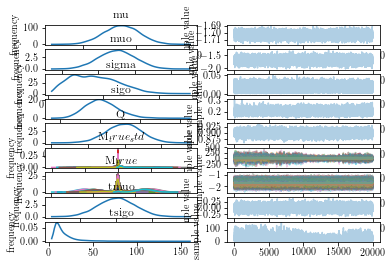

In [10]:
fit.plot()
plt.show()

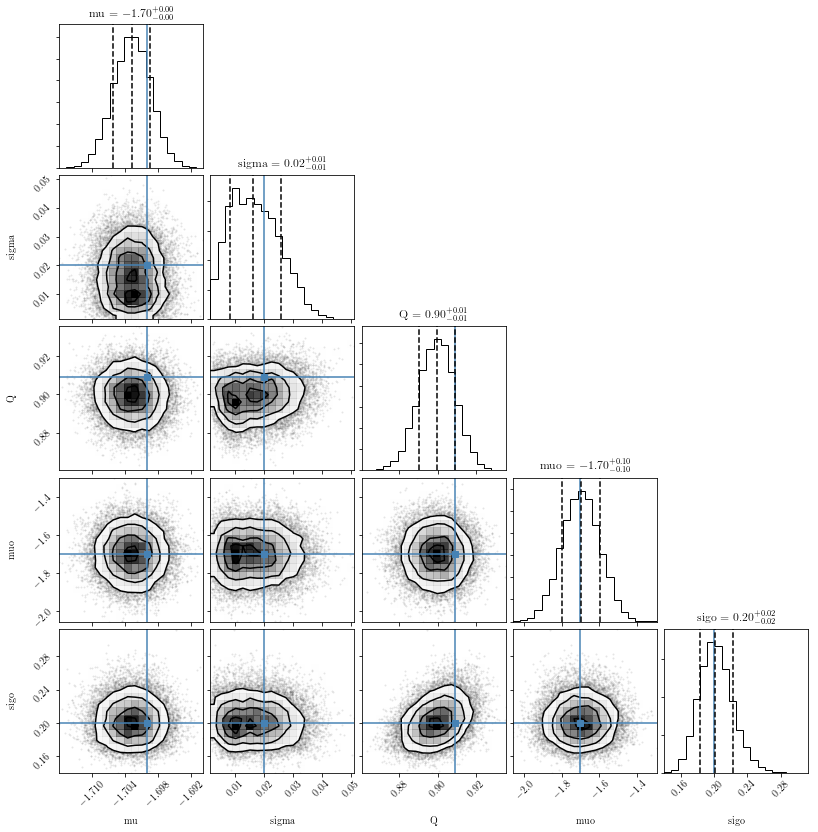

In [11]:
import corner
chain = np.array([fit['mu'],fit['sigma'],fit['Q'],fit['muo'],fit['sigo']]).T
truths=[-1.7,0.02,pQ,-1.7,0.2]
corner.corner(chain,labels=['mu','sigma','Q','muo','sigo'],\
                  truths=truths,\
                  quantiles=[0.16, 0.5, 0.84],\
                  show_titles=True, title_kwargs={"fontsize": 12})
plt.show()

In [12]:
rmu = np.median(fit['mu'])
rsigma = np.median(fit['sigma'])
rsigo = (np.median(fit['sigo']))
rmuo = (np.median(fit['muo']))
rQ = np.median(fit['Q'])

fg = normal(d, rmu, rsigma)
bg = normal(d, rmuo, rsigo)
L = rQ*fg + (1-rQ)*bg

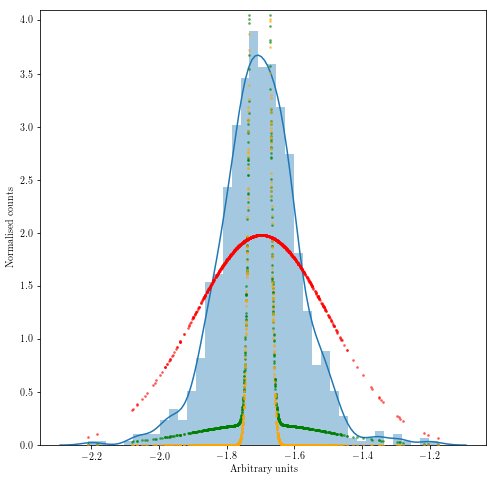

In [13]:
fig, ax = plt.subplots(1,figsize=(8,8))
sns.distplot(d,ax=ax)
ax.scatter(d,fg,s=3,label='Foreground', alpha=.5,c='orange',zorder=999)
ax.scatter(d,bg,s=3,label='Background', alpha=.5,c='red',zorder=998)
ax.scatter(d, L,s=3,label='True likelihood', alpha=.5,c='green',zorder=997)

ax.set_xlabel('Arbitrary units')
ax.set_ylabel('Normalised counts')
plt.show()

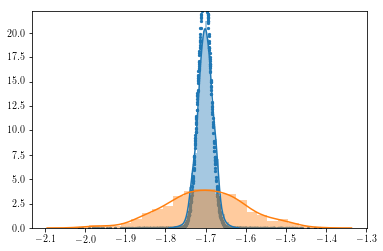

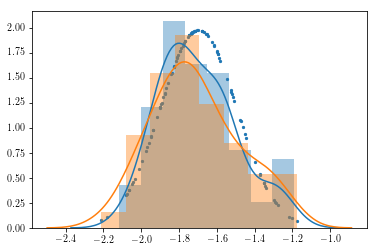

In [14]:
Mfg = normal(M, rmu, rsigma)
Mbg = normal(M0, rmuo, rsigo)
sns.distplot(M_true)
sns.distplot(M)
plt.scatter(M,Mfg,s=5)
plt.show()
sns.distplot(M_true0)
sns.distplot(M0)
plt.scatter(M0,Mbg,s=5)
plt.show()

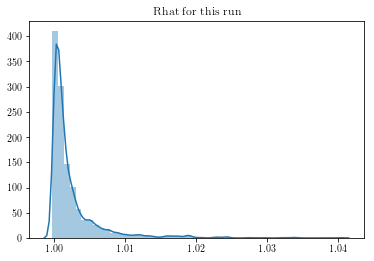

In [32]:
s = fit.summary()
sns.distplot(s['summary'][:,-1])
plt.title('Rhat for this run')
plt.show()